(sec-tutorial-ops-qubits)=

# Tutorial: Operations and Qubits

```{seealso}
The complete source code of this tutorial can be found in

{nb-download}`Operations and Qubits.ipynb`
```

## Gates, measurements and qubits

In the previous tutorials, experiments were created on the {ref}`quantum-device level<sec-user-guide-quantum-device>`. On this level,
operations are defined in terms of explicit signals and locations on the chip, rather than the qubit and the intended operation.
To work at a greater level of abstraction, `quantify-scheduler` allows creating operations on the
{ref}`quantum-circuit level<sec-user-guide-quantum-circuit>`.
Instead of signals, clocks, and ports, operations are defined by the effect they have on specific qubits. This representation of the schedules can be compiled to the quantum-device level to create the pulse schemes.

In this tutorial we show how to define operations on the {ref}`quantum-circuit level<sec-user-guide-quantum-circuit>`, combine them into schedules, and show their circuit-level visualization.
We go through the configuration file needed to compile the schedule to the quantum-device level and show how these configuration files can be created automatically and dynamically.
Finally, we showcase the hybrid nature of `quantify-scheduler`, allowing the scheduling of circuit-level and device-level operations side by side in the same schedule.

Many of the gates used in the circuit layer description are defined in
{class}`~quantify_scheduler.operations.gate_library` such as {class}`~quantify_scheduler.operations.gate_library.Reset`, {class}`~quantify_scheduler.operations.gate_library.X90` and
{class}`~quantify_scheduler.operations.gate_library.Measure`.
Operations are instantiated by providing them with the name of the qubit(s) on which
they operate:

In [1]:
from quantify_scheduler.operations.gate_library import CZ, Measure, Reset, X90

q0, q1 = ("q0", "q1")
X90(q0)
Measure(q1)
CZ(q0, q1)
Reset(q0);


Let's investigate the different components present in the circuit-level description of
the operation. As an example, we create a 45 degree rotation operation over the
x-axis.

In [2]:
from pprint import pprint
from quantify_scheduler.operations.gate_library import Rxy

rxy45 = Rxy(theta=45.0, phi=0.0, qubit=q0)
pprint(rxy45.data)


{'acquisition_info': [],
 'gate_info': {'operation_type': 'Rxy',
               'phi': 0.0,
               'plot_func': 'quantify_scheduler.schedules._visualization.circuit_diagram.gate_box',
               'qubits': ['q0'],
               'tex': '$R_{xy}^{45, 0}$',
               'theta': 45.0,
               'unitary': array([[0.92387953+0.j        , 0.        -0.38268343j],
       [0.        -0.38268343j, 0.92387953+0.j        ]])},
 'logic_info': {},
 'name': "Rxy(45, 0, 'q0')",
 'pulse_info': []}


As we can see, the structure of a circuit-level operation is similar to a pulse-level
operation. However, the information is contained inside the {code}`gate_info` entry rather
than the {code}`pulse_info` entry of the data dictionary.
Importantly, there is no device-specific information coupled to the operation such that
it represents the abstract notion of this qubit rotation, rather than how to perform it
on any physical qubit implementation.

The entries present above are documented in the `operation` schema.
Generally, these schemas are only important when defining custom operations, which is
not part of this tutorial. This schema can be inspected via:

In [3]:
import importlib.resources
import json
from quantify_scheduler import schemas

operation_schema = json.loads(importlib.resources.read_text(schemas, "operation.json"))
pprint(operation_schema["properties"]["gate_info"]["properties"])


{'operation_type': {'description': 'Defines what class of operations this gate '
                                   'refers to (e.g. Rxy, CZ etc.).',
                    'type': 'string'},
 'plot_func': {'description': 'reference to a function for plotting this '
                              'operation. If not specified, defaults to using '
                              ':func:`~quantify_scheduler.schedules._visualization.circuit_diagram.gate_box`.',
               'type': ['string', 'null']},
 'qubits': {'description': 'A list of strings indicating the qubits the gate '
                           'acts on. Valid qubits are strings that appear in '
                           'the device_config.json file.',
            'type': 'array'},
 'symmetric': {'description': 'A boolean to indicate whether a two qubit gate '
                              'is symmetric. This is used in the device config '
                              'compilation stage. By default, it is set as '
               

## Schedule creation from the circuit layer (Bell)

The circuit-level operations can be used to create a {class}`~quantify_scheduler.schedules.schedule.Schedule` within
`quantify-scheduler` using the same method as for the pulse-level operations.
This enables creating schedules on a more abstract level.
Here, we demonstrate this extra layer of abstraction by creating a {class}`~quantify_scheduler.schedules.schedule.Schedule` for measuring
Bell violations.

```{note}
Within a single {class}`~quantify_scheduler.schedules.schedule.Schedule`, high-level circuit layer operations can be mixed with quantum-device level operations. This mixed representation is useful for experiments where some pulses cannot easily be represented as qubit gates. An example of this is given by the `Chevron` experiment given in {ref}`Mixing pulse and circuit layer operations (Chevron)`.
```

As the first example, we want to create a schedule for performing the
[Bell experiment](https://en.wikipedia.org/wiki/Bell%27s_theorem).
The goal of the Bell experiment is to create a Bell state
{math}`|\Phi ^+\rangle=\frac{1}{2}(|00\rangle+|11\rangle)` which is a perfectly entangled state, followed by a measurement.
By rotating the measurement basis, or equivalently one of the qubits, it is possible
to observe violations of the CSHS inequality.

We create this experiment using the
{ref}`quantum-circuit level<sec-user-guide-quantum-circuit>` description.
This allows defining the Bell schedule as:

In [4]:
import numpy as np
from quantify_scheduler import Schedule
from quantify_scheduler.operations.gate_library import CZ, Measure, Reset, Rxy, X90

sched = Schedule("Bell experiment")

for acq_idx, theta in enumerate(np.linspace(0, 360, 21)):
    sched.add(Reset(q0, q1))
    sched.add(X90(q0))
    sched.add(X90(q1), ref_pt="start")  # Start at the same time as the other X90
    sched.add(CZ(q0, q1))
    sched.add(Rxy(theta=theta, phi=0, qubit=q0))

    sched.add(Measure(q0, acq_index=acq_idx), label="M q0 {:.2f} deg".format(theta))
    sched.add(  
        Measure(q1, acq_index=acq_idx),
        label="M q1 {:.2f} deg".format(theta),
        ref_pt="start",  # Start at the same time as the other measure
    )

sched


Schedule "Bell experiment" containing (66) 147  (unique) operations.

By scheduling 7 operations for 21 different values for {code}`theta` we indeed get a schedule containing 7\*21=147 operations. To minimize the size of the schedule, identical operations are stored only once. For example, the {class}`~quantify_scheduler.operations.gate_library.CZ` operation is stored only once but used 21 times, which leaves only 66 unique operations in the schedule.

```{note}
The acquisitions are different for every iteration due to their different {code}`acq_index`. The {class}`~quantify_scheduler.operations.gate_library.Rxy`-gate rotates over a different angle every iteration and must therefore also be different for every iteration (except for the last since {math}`R^{360}=R^0`). Hence the number of unique operations is 3\*21-1+4=66.
```

(sec-tutorial-ops-qubits-vis)=
## Visualizing the quantum circuit

We can directly visualize the created schedule on the
{ref}`quantum-circuit level<sec-user-guide-quantum-circuit>` with the {meth}`~quantify_scheduler.schedules.schedule.ScheduleBase.plot_circuit_diagram` method.
This visualization shows every operation on a line representing the different qubits.

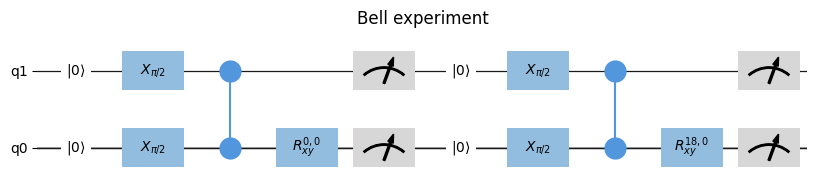

In [5]:
import matplotlib.pyplot as plt

_, ax = sched.plot_circuit_diagram()
# all gates are plotted, but it doesn't all fit in a matplotlib figure.
# Therefore we use :code:`set_xlim` to limit the number of gates shown.
ax.set_xlim(-0.5, 9.5)
plt.show()


In previous tutorials, we visualized the `schedules` on the pulse level using {meth}`~quantify_scheduler.schedules.schedule.ScheduleBase.plot_pulse_diagram` .
Up until now, however, all gates have been defined on the
{ref}`quantum-circuit level<sec-user-guide-quantum-circuit>` without defining the
corresponding pulse shapes.
Therefore, trying to run {meth}`~quantify_scheduler.schedules.schedule.ScheduleBase.plot_pulse_diagram` will raise an error which
signifies no {code}`pulse_info` is present in the schedule:

In [6]:
sched.plot_pulse_diagram()

RuntimeError: Attempting to sample schedule, but the schedule does not contain any `pulse_info`. Please verify that the schedule has been populated and device compilation has been performed.

And similarly for the {code}`timing_table`:

In [7]:
sched.timing_table

ValueError: Absolute time has not been determined yet. Please compile your schedule.

## Device configuration

Up until now, the schedule is not specific to any qubit implementation.
The aim of this section is to add device-specific information to the schedule.
This knowledge is contained in the {ref}`device configuration<sec-device-config>`, which we introduce in this section.
By compiling the schedule to the quantum-device layer, we incorporate the device configuration into the schedule (for example by adding pulse information to every gate) and thereby enable it to run on a specific qubit implementation.

To start this section, we will unpack the structure of the device configuration.
Here we will use an example device configuration for a transmon-based system that is used in the
`quantify-scheduler` test suite.

In [8]:
from quantify_scheduler.backends.circuit_to_device import DeviceCompilationConfig
from quantify_scheduler.schemas.examples.device_example_cfgs import (
    example_transmon_cfg,
)

device_cfg = DeviceCompilationConfig.model_validate(example_transmon_cfg)

list(device_cfg.model_dump())

['clocks', 'elements', 'edges', 'scheduling_strategy', 'compilation_passes']

Before explaining how this can be used to compile schedules, let us first investigate
the contents of the device configuration.

In [9]:
device_cfg.compilation_passes


[SimpleNodeConfig(name='circuit_to_device', compilation_func=<function compile_circuit_to_device_with_config_validation at 0x7f392df61af0>)]

The compilation passes of the device configuration specifies which function(s) will be used to 
compile the {class}`~.Schedule` to the {ref}`sec-user-guide-quantum-device`. In other words, 
it specifies how to interpret the qubit parameters present in the device configuration and achieve
the required gates. Let us briefly investigate the compilation function:

In [10]:
help(device_cfg.compilation_passes[0].compilation_func)


Help on function compile_circuit_to_device_with_config_validation in module quantify_scheduler.backends.circuit_to_device:

compile_circuit_to_device_with_config_validation(schedule: 'Schedule', config: 'CompilationConfig | DeviceCompilationConfig | Dict | None' = None, *, device_cfg: 'DeviceCompilationConfig | Dict | None' = None) -> 'Schedule'
    Add pulse information to all gates in the schedule.
    
    Before calling this function, the schedule can contain abstract operations (gates or
    measurements). This function adds pulse and acquisition information with respect to
    ``config`` as they are expected to arrive to device (latency or distortion corrections
    are not taken into account).
    
    From a point of view of :ref:`sec-compilation`, this function converts a schedule
    defined on a quantum-circuit layer to a schedule defined on a quantum-device layer.
    
    Parameters
    ----------
    schedule
        The schedule to be compiled.
    config
        Compila

The {ref}`device configuration <sec-device-config>` also contains the
parameters required by the backend for all qubits and edges.

In [11]:
print(list(device_cfg.elements))
print(list(device_cfg.edges))
print(list(device_cfg.clocks))


['q0', 'q1']
['q0_q1']
['q0.01', 'q0.ro', 'q1.01', 'q1.ro']


For every qubit and edge, we can investigate the contained parameters.

In [12]:
print(device_cfg.elements["q0"])
print(device_cfg.elements["q0"]["Rxy"].factory_kwargs)


{'reset': OperationCompilationConfig(factory_func=<class 'quantify_scheduler.operations.pulse_library.IdlePulse'>, factory_kwargs={'duration': 0.0002}, gate_info_factory_kwargs=None), 'Rxy': OperationCompilationConfig(factory_func=<function rxy_drag_pulse at 0x7f392df01790>, factory_kwargs={'amp180': 0.32, 'motzoi': 0.45, 'port': 'q0:mw', 'clock': 'q0.01', 'duration': 2e-08}, gate_info_factory_kwargs=['theta', 'phi']), 'Rz': OperationCompilationConfig(factory_func=<function phase_shift at 0x7f392df01a60>, factory_kwargs={'clock': 'q0.01'}, gate_info_factory_kwargs=['theta']), 'H': OperationCompilationConfig(factory_func=<function hadamard_as_y90z at 0x7f392ddae820>, factory_kwargs={'qubit': 'q0'}, gate_info_factory_kwargs=None), 'measure': OperationCompilationConfig(factory_func=<function dispersive_measurement at 0x7f392ddaea60>, factory_kwargs={'port': 'q0:res', 'clock': 'q0.ro', 'pulse_type': 'SquarePulse', 'pulse_amp': 0.25, 'pulse_duration': 1.6e-07, 'acq_delay': 1.2e-07, 'acq_dur

In [13]:
print(device_cfg.edges)


{'q0_q1': {'CZ': OperationCompilationConfig(factory_func=<function composite_square_pulse at 0x7f392ddae3a0>, factory_kwargs={'square_port': 'q0:fl', 'square_clock': 'cl0.baseband', 'square_amp': 0.5, 'square_duration': 2e-08, 'virt_z_parent_qubit_phase': 44, 'virt_z_parent_qubit_clock': 'q0.01', 'virt_z_child_qubit_phase': 63, 'virt_z_child_qubit_clock': 'q1.01'}, gate_info_factory_kwargs=None)}}


In [14]:
print(device_cfg.clocks)



{'q0.01': 6020000000.0, 'q0.ro': 7040000000.0, 'q1.01': 5020000000.0, 'q1.ro': 6900000000.0}


Lastly, the complete example device configuration (also see {class}`~quantify_scheduler.backends.graph_compilation.DeviceCompilationConfig`):

In [15]:
pprint(example_transmon_cfg)


{'clocks': {'q0.01': 6020000000.0,
            'q0.ro': 7040000000.0,
            'q1.01': 5020000000.0,
            'q1.ro': 6900000000.0},
 'compilation_passes': [{'compilation_func': 'quantify_scheduler.backends.circuit_to_device.compile_circuit_to_device_with_config_validation',
                         'name': 'circuit_to_device'}],
 'edges': {'q0_q1': {'CZ': {'factory_func': 'quantify_scheduler.operations.pulse_factories.composite_square_pulse',
                            'factory_kwargs': {'square_amp': 0.5,
                                               'square_clock': 'cl0.baseband',
                                               'square_duration': 2e-08,
                                               'square_port': 'q0:fl',
                                               'virt_z_child_qubit_clock': 'q1.01',
                                               'virt_z_child_qubit_phase': 63,
                                               'virt_z_parent_qubit_clock': 'q0.01',
       

## Quantum Devices and Elements

The {ref}`device configuration<sec-device-config>` contains all knowledge
of the physical device under test (DUT).
To generate these device configurations on the fly, `quantify-scheduler` provides the
{class}`~quantify_scheduler.device_under_test.quantum_device.QuantumDevice` and
{class}`~quantify_scheduler.device_under_test.device_element.DeviceElement` classes.

These classes contain the information necessary to generate the device configs and allow
changing their parameters on-the-fly.
The {class}`~quantify_scheduler.device_under_test.quantum_device.QuantumDevice` class
represents the DUT containing different {class}`~quantify_scheduler.device_under_test.device_element.DeviceElement` s.
Currently, `quantify-scheduler` contains the
{class}`~quantify_scheduler.device_under_test.transmon_element.BasicTransmonElement` class
to represent a fixed-frequency transmon qubit connected to a feedline. We show their interaction below:

In [16]:
from quantify_scheduler.device_under_test.quantum_device import QuantumDevice
from quantify_scheduler.device_under_test.transmon_element import BasicTransmonElement

# First create a device under test
dut = QuantumDevice("DUT")

# Then create a transmon element
qubit = BasicTransmonElement("qubit")

# Finally, add the transmon element to the QuantumDevice
dut.add_element(qubit)
dut, dut.elements()


(<QuantumDevice: DUT>, ['qubit'])

The different transmon properties can be set through attributes of the {class}`~quantify_scheduler.device_under_test.transmon_element.BasicTransmonElement` class instance, e.g.:

In [17]:
qubit.clock_freqs.f01(6e9)

print(list(qubit.submodules.keys()))
print()
for submodule_name, submodule in qubit.submodules.items():
    print(f"{qubit.name}.{submodule_name}: {list(submodule.parameters.keys())}")


['reset', 'rxy', 'measure', 'ports', 'clock_freqs']

qubit.reset: ['duration']
qubit.rxy: ['amp180', 'motzoi', 'duration']
qubit.measure: ['pulse_type', 'pulse_amp', 'pulse_duration', 'acq_channel', 'acq_delay', 'integration_time', 'reset_clock_phase', 'acq_weights_a', 'acq_weights_b', 'acq_weights_sampling_rate', 'acq_weight_type', 'acq_rotation', 'acq_threshold']
qubit.ports: ['microwave', 'flux', 'readout']
qubit.clock_freqs: ['f01', 'f12', 'readout']


The device configuration is now simply obtained using {code}`dut.generate_device_config()`.
In order for this command to provide a correct device configuration, the different properties need to be set to applicable values in the {class}`~quantify_scheduler.device_under_test.transmon_element.BasicTransmonElement` and {class}`~quantify_scheduler.device_under_test.quantum_device.QuantumDevice` objects.

In [18]:
pprint(dut.generate_device_config())


DeviceCompilationConfig(clocks={'qubit.01': 6000000000.0, 'qubit.12': nan, 'qubit.ro': nan}, elements={'qubit': {'reset': OperationCompilationConfig(factory_func=<class 'quantify_scheduler.operations.pulse_library.IdlePulse'>, factory_kwargs={'duration': 0.0002}, gate_info_factory_kwargs=None), 'Rxy': OperationCompilationConfig(factory_func=<function rxy_drag_pulse at 0x7f392df01790>, factory_kwargs={'amp180': nan, 'motzoi': 0, 'port': 'qubit:mw', 'clock': 'qubit.01', 'duration': 2e-08, 'reference_magnitude': None}, gate_info_factory_kwargs=['theta', 'phi']), 'Rz': OperationCompilationConfig(factory_func=<function phase_shift at 0x7f392df01a60>, factory_kwargs={'clock': 'qubit.01'}, gate_info_factory_kwargs=['theta']), 'H': OperationCompilationConfig(factory_func=<function hadamard_as_y90z at 0x7f392ddae820>, factory_kwargs={'qubit': 'qubit'}, gate_info_factory_kwargs=None), 'measure': OperationCompilationConfig(factory_func=<function dispersive_measurement at 0x7f392ddaea60>, factory_

## Specifying pulse magnitudes

```{warning}
Please note that currently only the user interface of the reference magnitude is defined. The physical magnitude scaling has not yet been implemented in any hardware backend. Therefore, changing the reference magnitude parameter will not have any physical effect in the current version of `quantify-scheduler`.
```

In the course of a quantum experiment, we may use a variety of electronic pulses of varying amplitudes or powers. The size of the pulses can potentially vary across many orders of magnitude. Additionally, there are many ways in which we might express the magnitude of said pulses (such as amplitude in volts, current in amps or power in dBm), which we may use in different contexts. When generating arbitrary waveforms, it is typical to use a DAC with limited dynamic range, so only a limited range of pulse amplitudes may be generated electronically. Therefore, devices such as variable attenuators or amplifiers are often used to produce pulses over many different orders of magnitude. In quantify, we provide the functionality to express the absolute magnitude of pulses in a range of different units, as well as to define the amplitude of any signal produced by an arbitrary waveform generator.

In the definition of any pulse operation in `quantify-scheduler`, there will typically be two parameters related to the magnitude of the pulse: the `amplitude` and the `reference_magnitude`. The `amplitude` is a unitless parameter which expresses the amplitude of the signal produced by the DAC of the signal generator, relative to the maximum output level of the DAC. The `amplitude` can vary from -1 to 1, where 1 is the maximum output level. Since `amplitude` is a relative scale, it does not express the absolute power level of the signal that reaches the device. This will be affected by a number of different variables, including any attenuation or gain that is applied to the signal after it produced by the DAC. In order to specify the magnitude of the signal in absolute terms, we have the `reference_magnitude` parameter. This provides a reference scale for the absolute magnitude of the signal when it reaches the device port in question. The reference magnitude can be specified in a number of different units: Volts, current in Amperes or power in dBm or W, depending on the physical implementation of the control pulse. The scaling is defined such that the power/amplitude of a pulse with amplitude 1 will have a value equal to the `reference_magnitude` when it reaches the port. How exactly this scaling is implemented physically will depend on the hardware backend. For example, it may be that a variable attenuation is applied to the pulse in order to scale its power to the right level. Or the gain of an amplifier will be varied. Whenever a quantify schedule is compiled, the quantify compilation backend will automatically compile all instructions necessary for all hardware instruments required to scale the pulse magnitude to the correct level.

The reference magnitude and amplitude of a pulse can both be configured via QCoDeS parameters in the device element. The pulse amplitude can be configured via a standard QCoDeS parameter, for example `qubit.rxy.amp180` can be used to set the pi-pulse amplitude of an RXY operation of a transmon qubit (between -1 and 1). The reference magnitude is configured slightly differently. Because of the need to express the reference magnitude in a variety of different units in different contexts, the reference magnitude is configured via a custom QCoDeS submodule within the device element - of class {class}`~quantify_scheduler.device_under_test.transmon_element.ReferenceMagnitude`. For example, we may have the submodule `qubit.rxy.reference_magnitude`, which is used to scale the amplitudes of the aforementioned RXY pulses. The {class}`~quantify_scheduler.device_under_test.transmon_element.ReferenceMagnitude` submodule contains three parameters, one for each of the possible units which the reference magnitude may be expressed in: Volts, dBm and Amperes. Only one of these unit parameters may have a defined numerical value at any given time. That is, if `reference_magnitude.dBm` is set to a particular value, both of the other parameters will automatically be set to `nan`. This allows the reference magnitude to be uniquely defined with respect to a particular unit. The defined unit and value of reference magnitude can be inquired via the `get_val_unit` method of the submodule, which returns both the numerical value and the unit in a tuple. If all of the reference magnitude parameters are `nan`, then no reference magnitude is defined and no extra scaling will be applied to the pulse.

## Mixing pulse and circuit layer operations (Chevron)

As well as defining our schedules in terms of gates, we can also mix the circuit layer
representation with pulse-level operations.
This can be useful for experiments involving pulses not easily represented by Gates,
such as the Chevron experiment.
In this experiment, we want to vary the length and amplitude of a square pulse between
X gates on a pair of qubits.

In [19]:
from quantify_scheduler import Schedule
from quantify_scheduler.operations.gate_library import Measure, Reset, X, X90
from quantify_scheduler.operations.pulse_library import SquarePulse
from quantify_scheduler.resources import ClockResource

sched = Schedule("Chevron Experiment")
acq_idx = 0

for duration in np.linspace(start=20e-9, stop=60e-9, num=6):
    for amp in np.linspace(start=0.1, stop=1.0, num=10):
        reset = sched.add(Reset("q0", "q1"))
        sched.add(X("q0"), ref_op=reset, ref_pt="end")  # Start at the end of the reset
        # We specify a clock for tutorial purposes, Chevron experiments do not necessarily use modulated square pulses
        square = sched.add(SquarePulse(amp=amp, duration=duration, port="q0:mw", clock="q0.01"))
        sched.add(X90("q0"), ref_op=square)  # Start at the end of the square pulse
        sched.add(X90("q1"), ref_op=square)
        sched.add(Measure(q0, acq_index=acq_idx), label=f"M q0 {acq_idx}")
        sched.add(
            Measure(q1, acq_index=acq_idx),
            label=f"M q1 {acq_idx}",
            ref_pt="start",  # Start at the same time as the other measure
        )

        acq_idx += 1


# Specify the frequencies for the clocks; this can also be done via the DeviceElement (BasicTransmonElement) instead
sched.add_resources([ClockResource("q0.01", 6.02e9), ClockResource("q1.01", 6.02e9), ClockResource("q0.ro", 5.02e9), ClockResource("q1.ro", 5.02e9)]) 

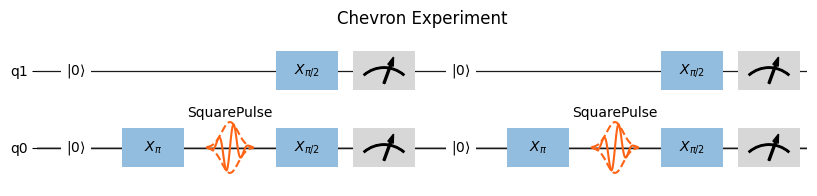

In [20]:
fig, ax = sched.plot_circuit_diagram()
ax.set_xlim(-0.5, 9.5)
for t in ax.texts:
    if t.get_position()[0] > 9.5:
        t.set_visible(False)


This example shows that we add gates using the same interface as pulses. Gates are Operations, and
as such support the same timing and reference operators as Pulses.


## Device and Hardware compilation combined: Serial Compiler

{class}`~quantify_scheduler.backends.graph_compilation.SerialCompiler` can be used to execute the device and hardware compilation separately, or execute both in one call. Here we will not set the hardware configuration thus only executing device compilation. The {ref}`Compiling to Hardware <sec-tutorial-compiling>` tutorial demonstrates how to set the hardware configuration.

{class}`~quantify_scheduler.backends.graph_compilation.SerialCompiler` requires a {class}`~quantify_scheduler.backends.graph_compilation.CompilationConfig` and this holds both the device and hardware configurations (when set). In the example below, we generate a {class}`~quantify_scheduler.backends.graph_compilation.CompilationConfig` via  {meth}`~quantify_scheduler.device_under_test.quantum_device.QuantumDevice.generate_compilation_config` of {class}`~quantify_scheduler.device_under_test.quantum_device.QuantumDevice`.

In [21]:
from quantify_scheduler.backends import SerialCompiler
from quantify_scheduler.device_under_test.quantum_device import QuantumDevice
from quantify_scheduler.device_under_test.transmon_element import BasicTransmonElement

dut.close()
dut = QuantumDevice("DUT")
q0 = BasicTransmonElement("q0")
q1 = BasicTransmonElement("q1")
dut.add_element(q0)
dut.add_element(q1)
dut.get_element("q0").rxy.amp180(0.65)
dut.get_element("q1").rxy.amp180(0.55)
dut.get_element("q0").measure.pulse_amp(0.28)
dut.get_element("q1").measure.pulse_amp(0.22)

compiler = SerialCompiler(name='compiler')
compiled_sched = compiler.compile(schedule=sched, config=dut.generate_compilation_config())

So, finally, we can show the timing table associated with the Chevron schedule and plot
its pulse diagram:

In [22]:
compiled_sched.timing_table.hide(slice(11, None), axis="index").hide(
    "waveform_op_id", axis="columns"
)


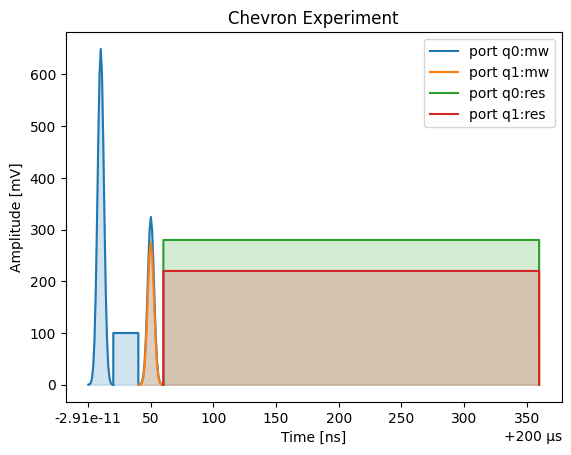

In [23]:
f, ax = compiled_sched.plot_pulse_diagram(x_range=(200e-6, 200.4e-6))